# Import Libraries

In [2]:
import numpy as np
import pandas as pd 
import time 
import re

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
english_stop_words = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# machine learning

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


from sklearn.metrics import classification_report

import seaborn as sns
sns.set(style ='whitegrid')
pd.set_option('display.max_columns',None)


In [3]:
headers=['Tweet_ID','Entity','Sentiment','Tweet_content']

train_df=pd.read_csv('twitter_training.csv', sep=',', names=headers)

valid_df=pd.read_csv('twitter_validation.csv', sep=',', names=headers)

In [4]:
train_df.sample(5)

,Tweet_ID,Entity,Sentiment,Tweet_content
58267,11590,TomClancysRainbowSix,Neutral,@ Rainbow6Game activated the leaderboard
31135,7348,LeagueOfLegends,Negative,@ LeagueOfLegends
65857,6879,johnson&johnson,Neutral,Johnson & Johnson halts sales of talc-based ba...
21239,4036,CS-GO,Neutral,<unk>
67335,7131,johnson&johnson,Neutral,Johnson & Johnson Halting Sale Off Talcum Home...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       74682 non-null  int64 
 1   Entity         74682 non-null  object
 2   Sentiment      74682 non-null  object
 3   Tweet_content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


# Exploratory Data Analysis

In [6]:
train_df['Entity'].value_counts()

TomClancysRainbowSix                 2400
MaddenNFL                            2400
Microsoft                            2400
LeagueOfLegends                      2394
CallOfDuty                           2394
Verizon                              2382
CallOfDutyBlackopsColdWar            2376
ApexLegends                          2376
Facebook                             2370
WorldOfCraft                         2364
Dota2                                2364
NBA2K                                2352
TomClancysGhostRecon                 2346
Battlefield                          2346
FIFA                                 2340
Xbox(Xseries)                        2334
Overwatch                            2334
johnson&johnson                      2328
Amazon                               2316
PlayStation5(PS5)                    2310
HomeDepot                            2310
Cyberpunk2077                        2304
CS-GO                                2304
GrandTheftAuto(GTA)               

In [7]:
train_df['Sentiment'].value_counts()

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: Sentiment, dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

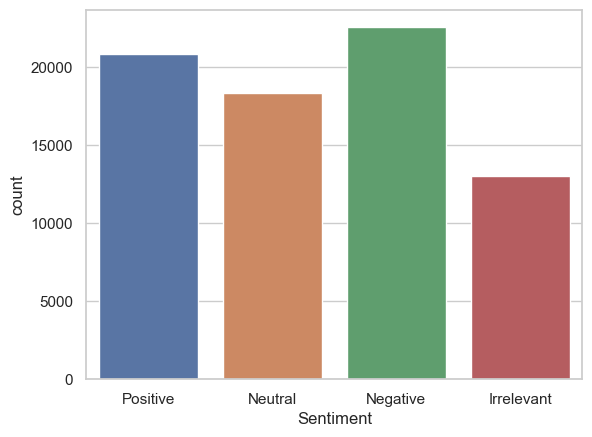

In [9]:
sns.countplot(x=train_df['Sentiment'])

In [10]:
train_df.duplicated().sum()

2700

In [11]:
train_df= train_df.drop_duplicates()

<AxesSubplot:ylabel='Sentiment'>

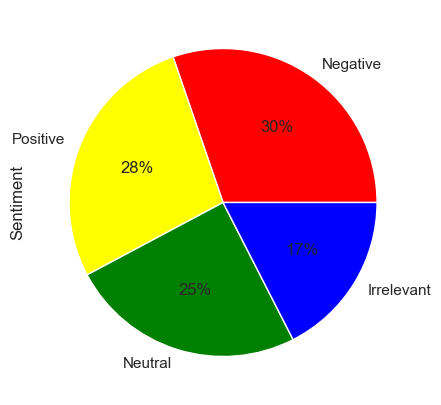

In [12]:
train_df.Sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%',figsize=(5,5),colors=["red", "yellow", "green",'blue'])


<AxesSubplot:xlabel='Entity'>

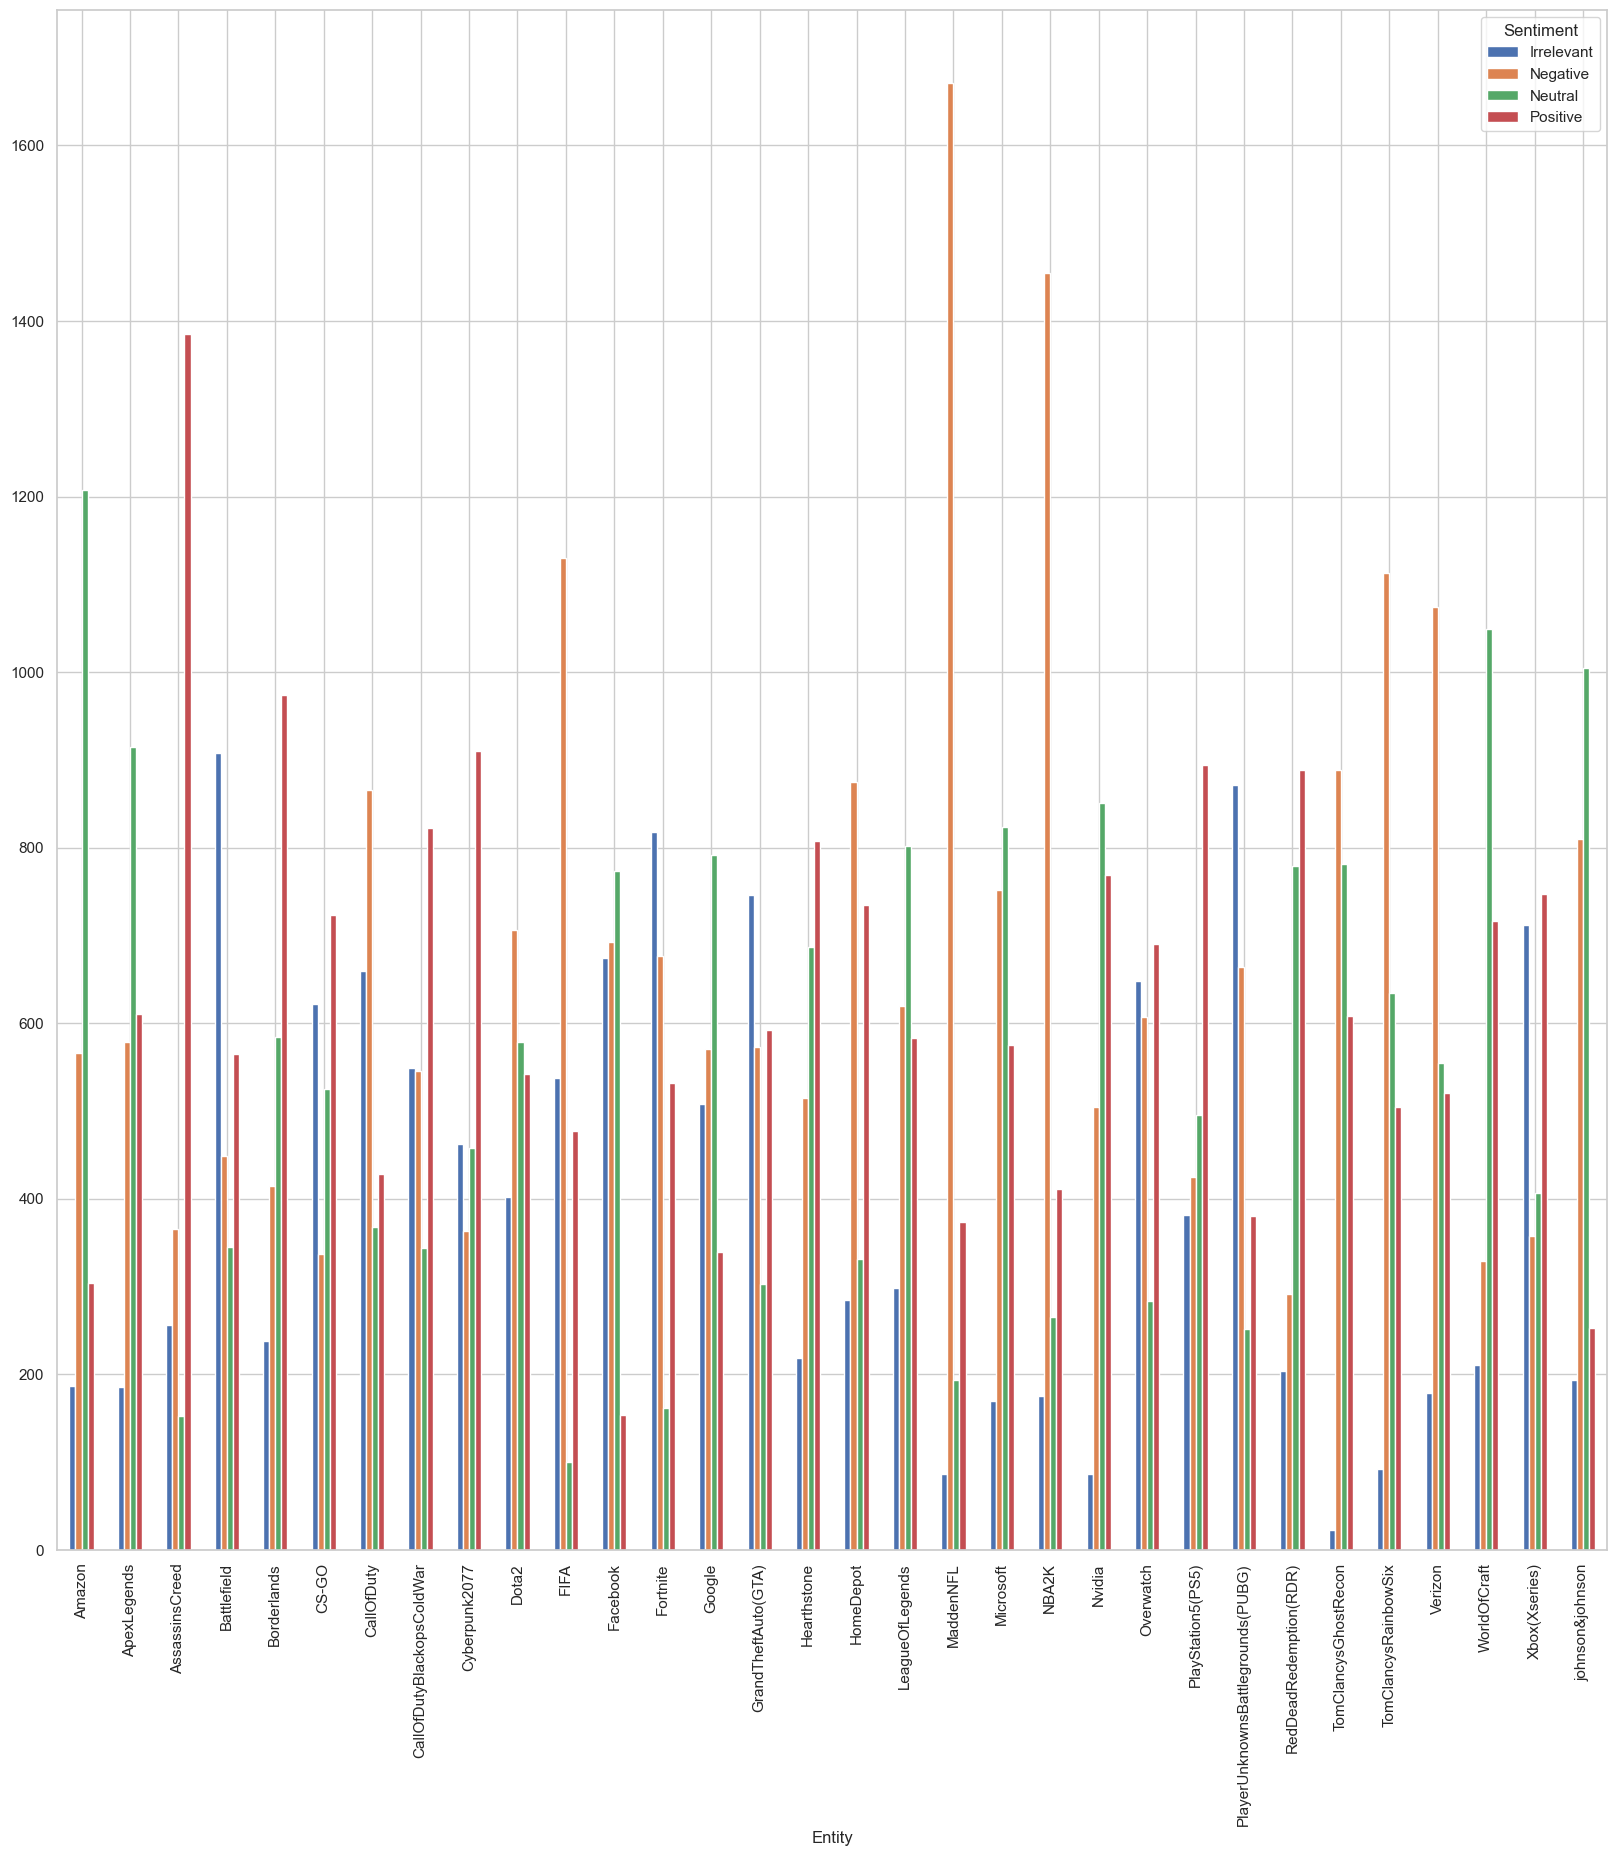

In [13]:
Twitter_sentiment = train_df.groupby(['Entity', 'Sentiment']).Sentiment.count().unstack()
Twitter_sentiment.plot(kind='bar',figsize=(20,20))

# Data Cleaning

In [14]:
# encoder for target feature
from sklearn import preprocessing
lb = preprocessing.LabelEncoder()
train_df['Sentiment']=lb.fit_transform(train_df['Sentiment'])

In [15]:
train_df['Tweet_content'].isnull().sum()

326

In [16]:
train_df.dropna(axis=0, inplace=True)

In [17]:
tweet_train  = train_df["Tweet_content"]
tweet_train

0        im getting on borderlands and i will murder yo...
1        I am coming to the borders and I will kill you...
2        im getting on borderlands and i will kill you ...
3        im coming on borderlands and i will murder you...
4        im getting on borderlands 2 and i will murder ...
                               ...                        
74677    Just realized that the Windows partition of my...
74678    Just realized that my Mac window partition is ...
74679    Just realized the windows partition of my Mac ...
74680    Just realized between the windows partition of...
74681    Just like the windows partition of my Mac is l...
Name: Tweet_content, Length: 71656, dtype: object

In [18]:
tweet_valid=valid_df["Tweet_content"]

In [19]:
target=train_df['Sentiment']

In [20]:
REPLACE_WITH_SPACE = re.compile("(@)")
SPACE = " "

def preprocess_reviews(reviews):  
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line.lower()) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(tweet_train)
reviews_valid_clean = preprocess_reviews(tweet_valid)

In [21]:
# Remove Stop Words
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in english_stop_words]))
    return removed_stop_words

no_stop_words_train = remove_stop_words(reviews_train_clean)
no_stop_words_valid = remove_stop_words(reviews_valid_clean)

In [22]:
# Stemming
def get_stemmed_text(corpus):
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

stemmed_reviews_train = get_stemmed_text(no_stop_words_train)
stemmed_reviews_test = get_stemmed_text(no_stop_words_valid)

In [23]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(stemmed_reviews_train)
X = tfidf_vectorizer.transform(stemmed_reviews_train)
X_test = tfidf_vectorizer.transform(stemmed_reviews_test)

X_train, X_val, y_train, y_val = train_test_split(X, target, train_size = 0.75)

In [24]:

# def get_lemmatized_text(corpus):
    
#     lemmatizer = WordNetLemmatizer()
#     return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

# lemmatized_reviews_train = get_lemmatized_text(no_stop_words_train)
# lemmatized_reviews_valid = get_lemmatized_text(no_stop_words_valid)

In [25]:
# cv = CountVectorizer(binary=True)
# cv.fit(lemmatized_reviews_train)
# X = cv.transform(lemmatized_reviews_train)
# X_test = cv.transform(lemmatized_reviews_valid)

# X_train, X_val, y_train, y_val = train_test_split( X, target, train_size = 0.75)
 

In [26]:
# tfidf_vectorizer = TfidfVectorizer()
# tfidf_vectorizer.fit(lemmatized_reviews_train)
# X = tfidf_vectorizer.transform(lemmatized_reviews_train)
# X_test = tfidf_vectorizer.transform(lemmatized_reviews_valid)

# X_train, X_val, y_train, y_val = train_test_split(X, target, train_size = 0.75)

In [27]:
   
lr = LogisticRegression(C=1)
lr.fit(X_train, y_train)
print (classification_report(y_val, lr.predict(X_val)))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71      3157
           1       0.78      0.83      0.80      5453
           2       0.74      0.75      0.75      4409
           3       0.77      0.79      0.78      4895

    accuracy                           0.77     17914
   macro avg       0.77      0.76      0.76     17914
weighted avg       0.77      0.77      0.77     17914



C:\Users\WELCOME\Desktop\Plan_2022\Epslon\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
clf= MultinomialNB()

clf.fit(X_train, y_train)
y_pred=clf.predict(X_val)
print(classification_report(y_val,y_pred))


              precision    recall  f1-score   support

           0       0.95      0.40      0.56      3157
           1       0.64      0.90      0.75      5453
           2       0.83      0.63      0.72      4409
           3       0.70      0.81      0.75      4895

    accuracy                           0.72     17914
   macro avg       0.78      0.68      0.69     17914
weighted avg       0.76      0.72      0.71     17914



In [ ]:
text_classifier = RandomForestClassifier(n_estimators=500, random_state=0)
text_classifier.fit(X_train, y_train)

y_pred=text_classifier.predict(X_val)
print(classification_report(y_val,y_pred))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train,y_train)
y_pred = knn_model.predict(X_val)
print(classification_report(y_val,y_pred))

In [ ]:
svm = LinearSVC(C=0.5)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_val)
print(classification_report(y_val,y_pred))